In [114]:
%pip install numpy
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import random
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NUM_GENERATIONS = 500
MUTATION_PROB = 0.1
MAX_STAGNANT = 200  # Stop if no improvement for 200 generations


DEPOT = (50, 50)

X_RANGE = (0, 100)
Y_RANGE = (0, 100)

# --- Helper Functions ---
def euclidean_distance(p1, p2):
    """Calculate Euclidean distance between two points."""
    return math.hypot(p1[0] - p2[0], p1[1] - p2[1])


def calculate_distance_matrix(locations):
    """Precompute pairwise distances between all locations."""
    N = len(locations)
    distance_matrix = [[0.0 for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            distance_matrix[i][j] = euclidean_distance(locations[i], locations[j])

    return distance_matrix



# --- Genetic Algorithm Components ---
def create_individual(num_customers, num_vehicles):
    """Random initial distribution: allow some routes to remain empty."""
    customers = list(range(1, num_customers + 1))
    random.shuffle(customers)

    routes = [[] for _ in range(num_vehicles)]
    for customer in customers:
      routes[random.randint(0, num_vehicles - 1)].append(customer)

    # Add depot as start and end points for each vehicle route; otherwise [0,0]
    return [[0] + route + [0] if route else [0, 0] for route in routes]



def solution_distance(solution, distance_matrix):
    """Compute total distance of all routes in a solution."""
    total = 0.0
    for route in solution:
      if len(route) > 2: # Skip empty [0, 0] routes
          for i in range(len(route) - 1):
              total += distance_matrix[route[i]][route[i+1]]

    return total


# Used ChatGPT to adjust the crossover for the Vehicle Routing Problem
def crossover(parent1, parent2, num_vehicles, pc=0.8):
    """Route-based crossover that can produce empty routes."""

    #With probability (1 - pc), skip crossover and just return a copy of a parent
    if random.random() > pc:
        return [route[:] for route in parent1]

    child = [[] for _ in range(num_vehicles)]
    # Randomly choose a number of routes to take from parent1
    chosen_routes = random.sample(range(num_vehicles), k=random.randint(1, num_vehicles))
    assigned = set()

    for i in chosen_routes:
      child[i] = parent1[i][1:-1] # Customers only, i.e. skip start and end depot
      assigned.update(child[i])


    # Get all customers from parent2 that haven't already been assigned
    unassigned_customers = []
    for route in parent2:
      for customer in route[1:-1]:  # skip depot at start and end
        if customer not in assigned:
          unassigned_customers.append(customer)

    # Try to assign these customers to child routes,
    # roughly matching the length of the routes in parent2
    customer_index = 0
    for vehicle_index in range(num_vehicles):
        target_length = len(parent2[vehicle_index]) - 2  # exclude depot
        while (customer_index < len(unassigned_customers) and
              len(child[vehicle_index]) < target_length):
            customer = unassigned_customers[customer_index]
            child[vehicle_index].append(customer)
            customer_index += 1



    return [[0] + route + [0] if route else [0, 0] for route in child]



def tournament_selection(population, distance_matrix, k=3):
    """Select one solution via tournament selection."""
    candidates = random.sample(population, k)
    #print(f"Tournament: {tournament}")
    return min(candidates, key=lambda x: solution_distance(x, distance_matrix))


# Used ChatGPT to optimize the mutation for VRP
def mutate(solution, mutation_prob):
    """Move customer between routes (possibly emptying one route)."""
    if random.random() > mutation_prob:
        return solution

    new_solution = [route[:] for route in solution]
    non_epmty = [i for i, route in enumerate(new_solution) if len(route) > 2]
    if not non_epmty:
      return new_solution

    src = random.choice(non_epmty)
    dst = random.choice([i for i in range(len(new_solution)) if i != src])


    i = random.randint(1, len(new_solution[src]) - 2)
    customer = new_solution[src].pop(i)

    insert_pos = random.randint(1, len(new_solution[dst]) -1)
    new_solution[dst].insert(insert_pos, customer)
    return new_solution


# --- Main Genetic Algorithm ---
def genetic_algorithm(distance_matrix, num_customers, pop_size=20, num_vehicles=3, generations=300, mutation_prob=0.1, tournament_size=3):
    """Run a genetic algorithm for vehicle routing problem."""
    population = [create_individual(num_customers, num_vehicles) for _ in range(pop_size)]
    all_histories = []

    best_distance_so_far = float('inf')
    stagnant_generations = 0

    for gen in range(generations):
        population.sort(key=lambda s: solution_distance(s, distance_matrix))
        current_best = solution_distance(population[0], distance_matrix)
        all_histories.append(current_best)

        if current_best < best_distance_so_far:
            best_distance_so_far = current_best
            stagnant_generations = 0
        else:
            stagnant_generations += 1

        if stagnant_generations >= MAX_STAGNANT:
            print(f"No improvement for {MAX_STAGNANT} generations. Terminating at generation {gen}.")
            break
        
        #print(f"Generation {gen}: Best Distance = {current_best:.2f}")

        new_population = []
        while len(new_population) < pop_size:
            p1 = tournament_selection(population, distance_matrix, tournament_size)
            p2 = tournament_selection(population, distance_matrix, tournament_size)
            c1, c2 = crossover(p1, p2, num_vehicles), crossover(p2, p1, num_vehicles)

            c1 = mutate(c1, mutation_prob)
            c2 = mutate(c2, mutation_prob)
            new_population.append(c1)
            if len(new_population) < pop_size:
                new_population.append(c2)

        # Elitism; Keep the best solution from current generation
        population = [population[0]] + new_population[:-1]


    best_solution = min(population, key=lambda s: solution_distance(s, distance_matrix))
    best_solution = [r for r in best_solution if len(r) > 2]
    return best_solution, solution_distance(best_solution, distance_matrix), all_histories



def run_experiment(generations, mutation_prob, distance_matrix, num_runs=20):
    results = {}
    best_routes= []
    all_histories = []
    best_solution_overall = None
    best_distance_overall = float('inf')

    start_time = time.time()

    for _ in range(num_runs):
        best_solution, best_distance, history = genetic_algorithm(
        distance_matrix,
        num_customers=NUM_CUSTOMERS,
        num_vehicles=NUM_VEHICLES,
        pop_size=NUM_CUSTOMERS,
        generations=NUM_GENERATIONS,
        mutation_prob=MUTATION_PROB
        )
        best_routes.append(best_distance)
        all_histories.append(history)

        if best_distance < best_distance_overall:
            best_distance_overall = best_distance
            best_solution_overall = best_solution
    
    end_time = time.time()
    total_time = end_time - start_time
    avg_run_time = total_time/num_runs
    df = pd.DataFrame(all_histories).T  # Transpose to get generations as rows
    avg_history = df.mean(axis=1).to_numpy()
    results = {
        "best": min(best_routes),
        "worst": max(best_routes),
        "mean": np.mean(best_routes),
        "std_dev": np.std(best_routes),
        "avg_best_fitness": avg_history,
        "avg_run_time": avg_run_time
    }

    print(f"Statistics for Population Size {NUM_CUSTOMERS}")
    print(f"Best: {min(best_routes):.2f}, Worst: {max(best_routes):.2f}, Mean: {np.mean(best_routes):.2f}, Std Dev: {np.std(best_routes):.2f}\n")
    print(f"Average Time per Run: {avg_run_time:.2f} seconds\n")

    return results, best_solution_overall


def plot_route(solution, locations):
    plt.figure(figsize=(10, 8))
    for vehicle_idx, route in enumerate(solution):
        route_coords = [locations[i] for i in route]
        xs, ys = zip(*route_coords)
        plt.plot(xs, ys, marker='o', label=f"Vehicle {vehicle_idx + 1}")


        print(f"Vehicle {vehicle_idx + 1}: " + " -> ".join(map(str, route)))

    plt.scatter(*DEPOT, color='red', s=100, label='Depot')
    for i, (x, y) in enumerate(locations[1:], start=1):
        plt.text(x, y, f"C{i}", fontsize=9)

    plt.title("Best Route for Vehicles")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

In [116]:
customers_small_1 = [(15, 23), (48, 55), (1, 54), (37, 63), (83, 45), (99, 93), (38, 32), (12, 22), (79, 49), (26, 24), (87, 31), (13, 73), (90, 74), (66, 61), (75, 71), (69, 5), (78, 11), (45, 88), (65, 99), (6, 31)]
customers_small_2 = [(52, 36), (92, 81), (3, 96), (40, 77), (83, 66), (74, 0), (19, 53), (80, 36), (77, 42), (86, 94), (67, 67), (34, 24), (20, 29), (84, 4)]
customers_medium_1 = [(49, 24), (29, 78), (0, 97), (63, 2), (52, 96), (96, 34), (63, 78), (45, 75), (13, 63), (76, 87), (7, 75), (53, 22), (93, 89), (1, 23), (30, 86), (25, 90)]
customer_medium_2 = [(70, 86), (51, 54), (51, 41), (78, 90), (11, 21), (42, 38), (47, 88), (33, 78), (14, 2), (44, 42), (91, 20), (46, 51), (88, 41), (92, 59), (2, 83), (58, 1), (88, 20), (93, 65), (84, 61), (29, 14), (94, 29), (43, 83), (56, 61), (21, 18), (83, 72), (76, 96), (58, 91)]
customer_large_1 = [(27, 95), (24, 97), (91, 79), (79, 76), (2, 76), (58, 34), (6, 75), (36, 66), (23, 8), (54, 59), (22, 53), (64, 20), (39, 0), (50, 95), (10, 76), (88, 85), (49, 12), (97, 36), (76, 94), (83, 59), (16, 63), (99, 85), (30, 8), (82, 84), (71, 1), (80, 40), (21, 97), (2, 34), (53, 82), (58, 47), (99, 65), (15, 43), (0, 14), (19, 4), (54, 76), (90, 100)]
customer_large_2 = [(92, 92), (98, 9), (65, 71), (77, 96), (5, 75), (25, 8), (6, 64), (30, 32), (6, 65), (51, 9), (1, 22), (90, 63), (94, 17), (20, 45), (70, 79), (74, 69), (31, 93), (30, 36), (82, 41), (67, 87), (26, 55), (17, 63), (80, 20), (57, 71), (79, 94), (17, 86), (87, 57), (81, 32), (9, 61), (51, 89), (41, 94), (71, 83), (68, 0), (53, 8), (98, 71), (59, 40), (24, 50), (97, 25), (3, 73), (72, 97), (61, 68), (7, 11), (24, 63), (46, 27), (12, 20), (80, 2), (34, 100), (39, 74), (55, 41)]

print(len(customer_large_2))
vehicles_small_1 = 7
vehicles_small_2 = 3
vehicles_medium_1 = 14
vehicles_medium_2 = 23
vehicles_large_1 = 29
vehicles_large_2 = 45




49



--- Running Scenario: Small 1 ---
No improvement for 200 generations. Terminating at generation 362.
No improvement for 200 generations. Terminating at generation 455.
No improvement for 200 generations. Terminating at generation 360.
No improvement for 200 generations. Terminating at generation 453.
Statistics for Population Size 20
Best: 507.56, Worst: 671.38, Mean: 575.76, Std Dev: 43.86

Average Time per Run: 0.11 seconds

Best Distance for Small 1: 507.56
Vehicle 1: 0 -> 14 -> 13 -> 6 -> 19 -> 2 -> 0
Vehicle 2: 0 -> 4 -> 18 -> 12 -> 3 -> 20 -> 8 -> 1 -> 10 -> 7 -> 0
Vehicle 3: 0 -> 17 -> 16 -> 11 -> 5 -> 9 -> 15 -> 0


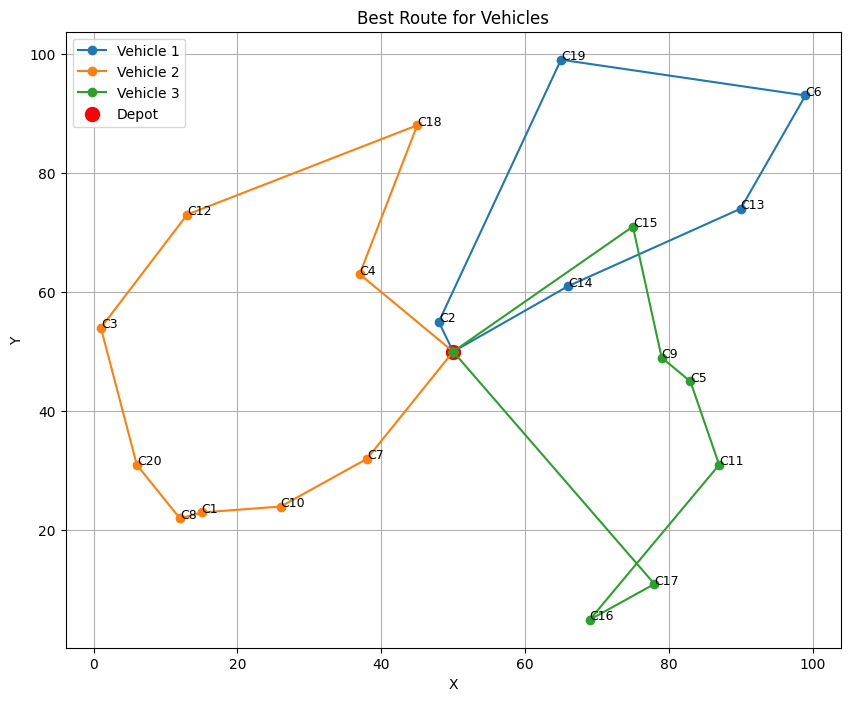


--- Running Scenario: Small 2 ---
No improvement for 200 generations. Terminating at generation 353.
No improvement for 200 generations. Terminating at generation 247.
No improvement for 200 generations. Terminating at generation 295.
No improvement for 200 generations. Terminating at generation 330.
No improvement for 200 generations. Terminating at generation 329.
No improvement for 200 generations. Terminating at generation 322.
No improvement for 200 generations. Terminating at generation 425.
No improvement for 200 generations. Terminating at generation 456.
No improvement for 200 generations. Terminating at generation 377.
No improvement for 200 generations. Terminating at generation 294.
No improvement for 200 generations. Terminating at generation 288.
No improvement for 200 generations. Terminating at generation 261.
No improvement for 200 generations. Terminating at generation 331.
No improvement for 200 generations. Terminating at generation 357.
No improvement for 200 gene

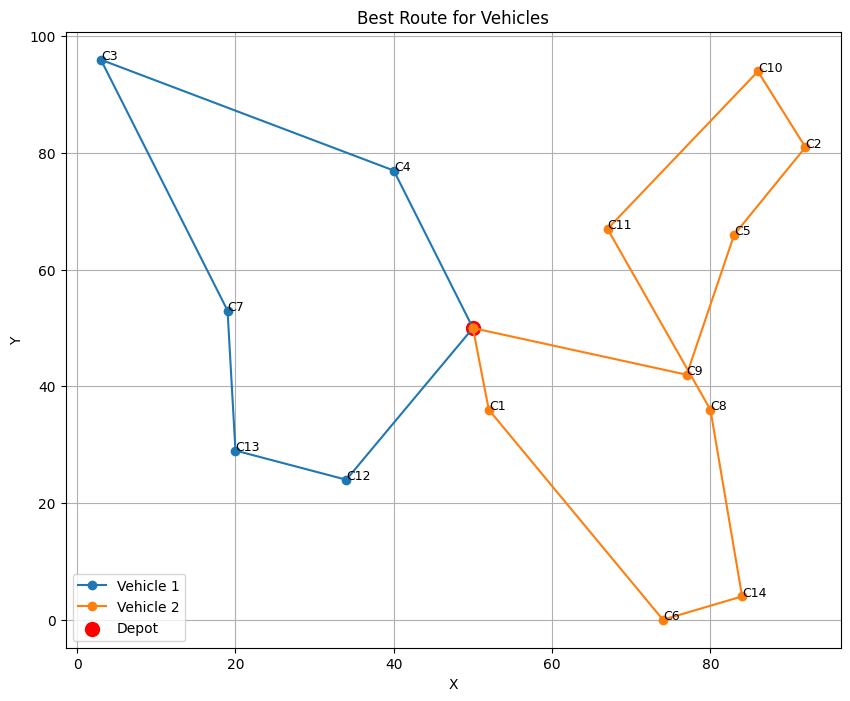


--- Running Scenario: Medium 1 ---
No improvement for 200 generations. Terminating at generation 333.
No improvement for 200 generations. Terminating at generation 388.
No improvement for 200 generations. Terminating at generation 423.
No improvement for 200 generations. Terminating at generation 393.
No improvement for 200 generations. Terminating at generation 449.
No improvement for 200 generations. Terminating at generation 479.
No improvement for 200 generations. Terminating at generation 384.
No improvement for 200 generations. Terminating at generation 319.
No improvement for 200 generations. Terminating at generation 327.
No improvement for 200 generations. Terminating at generation 471.
Statistics for Population Size 16
Best: 559.96, Worst: 666.37, Mean: 619.64, Std Dev: 30.23

Average Time per Run: 0.09 seconds

Best Distance for Medium 1: 559.96
Vehicle 1: 0 -> 14 -> 9 -> 11 -> 3 -> 16 -> 2 -> 15 -> 0
Vehicle 2: 0 -> 5 -> 13 -> 10 -> 7 -> 8 -> 4 -> 1 -> 12 -> 6 -> 0


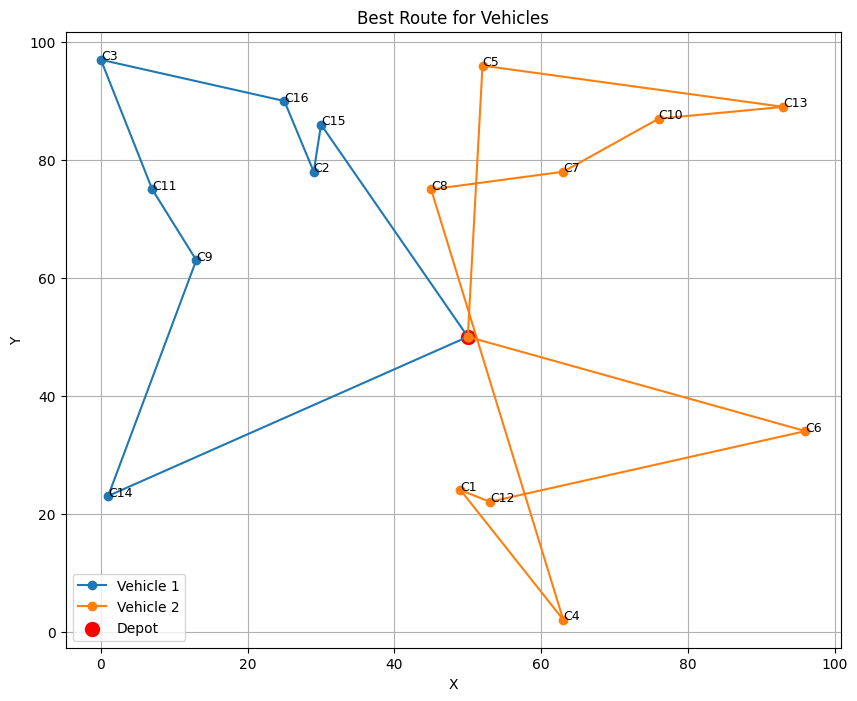


--- Running Scenario: Medium 2 ---
Statistics for Population Size 27
Best: 686.09, Worst: 897.91, Mean: 796.98, Std Dev: 58.05

Average Time per Run: 0.28 seconds

Best Distance for Medium 2: 686.09
Vehicle 1: 0 -> 15 -> 7 -> 26 -> 1 -> 27 -> 22 -> 8 -> 12 -> 0
Vehicle 2: 0 -> 2 -> 23 -> 0
Vehicle 3: 0 -> 6 -> 5 -> 24 -> 9 -> 20 -> 10 -> 3 -> 0
Vehicle 4: 0 -> 19 -> 14 -> 18 -> 25 -> 4 -> 0
Vehicle 5: 0 -> 16 -> 17 -> 21 -> 11 -> 13 -> 0


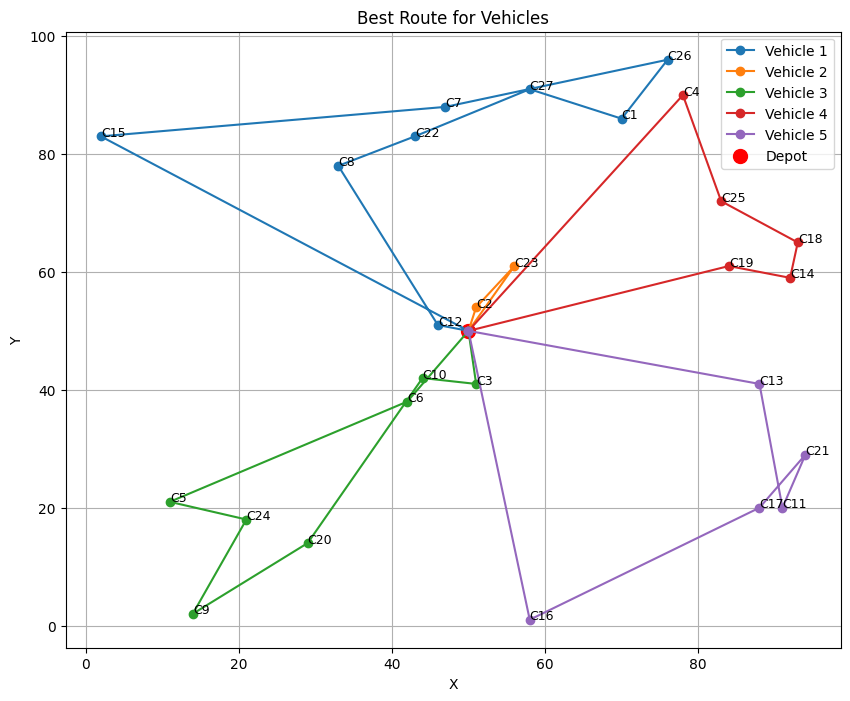


--- Running Scenario: Large 1 ---
Statistics for Population Size 36
Best: 1046.11, Worst: 1288.34, Mean: 1155.36, Std Dev: 62.10

Average Time per Run: 0.44 seconds

Best Distance for Large 1: 1046.11
Vehicle 1: 0 -> 10 -> 24 -> 19 -> 4 -> 0
Vehicle 2: 0 -> 20 -> 31 -> 3 -> 16 -> 36 -> 22 -> 18 -> 26 -> 0
Vehicle 3: 0 -> 15 -> 5 -> 7 -> 8 -> 0
Vehicle 4: 0 -> 29 -> 1 -> 2 -> 27 -> 0
Vehicle 5: 0 -> 35 -> 14 -> 0
Vehicle 6: 0 -> 28 -> 9 -> 23 -> 34 -> 17 -> 6 -> 30 -> 0
Vehicle 7: 0 -> 12 -> 25 -> 13 -> 33 -> 32 -> 11 -> 21 -> 0


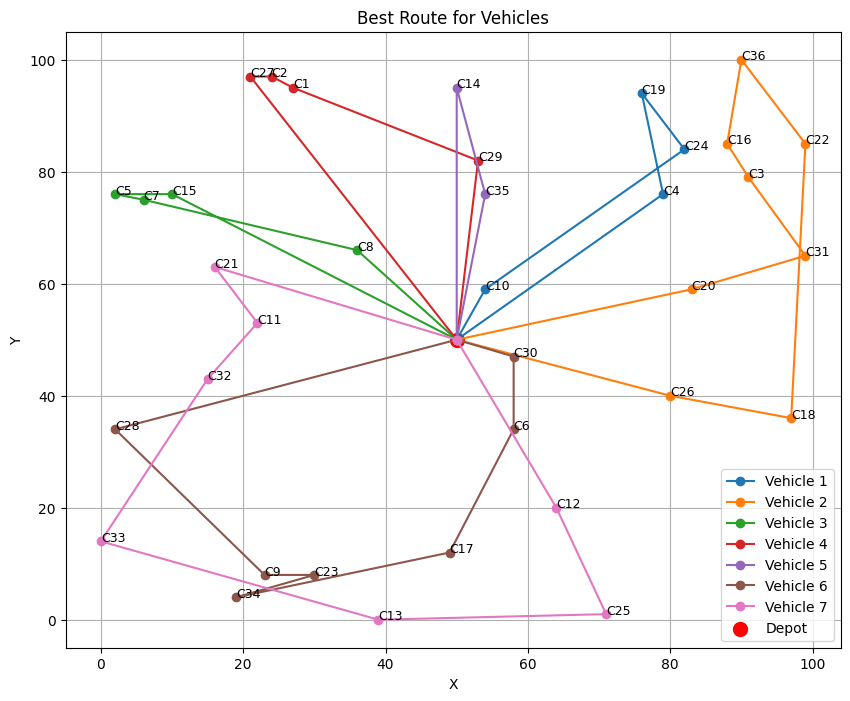


--- Running Scenario: Large 2 ---
Statistics for Population Size 49
Best: 1335.70, Worst: 1682.99, Mean: 1450.83, Std Dev: 79.90

Average Time per Run: 1.04 seconds

Best Distance for Large 2: 1335.70
Vehicle 1: 0 -> 31 -> 17 -> 26 -> 5 -> 39 -> 0
Vehicle 2: 0 -> 8 -> 18 -> 11 -> 29 -> 9 -> 7 -> 48 -> 47 -> 0
Vehicle 3: 0 -> 21 -> 43 -> 22 -> 14 -> 37 -> 0
Vehicle 4: 0 -> 13 -> 2 -> 38 -> 28 -> 19 -> 0
Vehicle 5: 0 -> 6 -> 34 -> 10 -> 44 -> 36 -> 49 -> 0
Vehicle 6: 0 -> 45 -> 42 -> 46 -> 23 -> 33 -> 0
Vehicle 7: 0 -> 24 -> 30 -> 15 -> 20 -> 40 -> 16 -> 0
Vehicle 8: 0 -> 3 -> 32 -> 4 -> 25 -> 1 -> 0
Vehicle 9: 0 -> 27 -> 12 -> 35 -> 41 -> 0


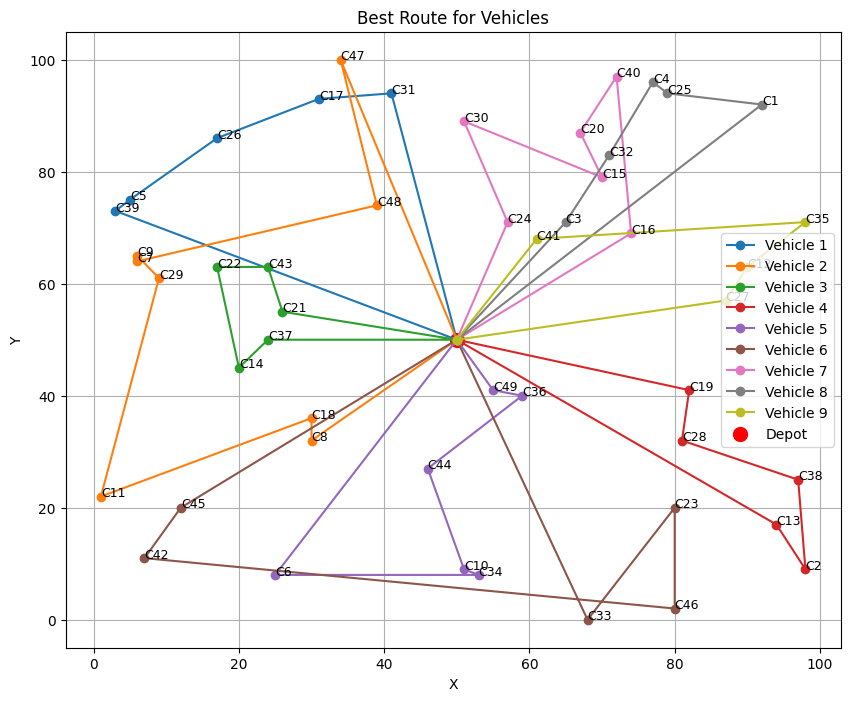

In [117]:
# Define all scenarios
scenarios = [
    {"name": "Small 1", "customers": customers_small_1, "vehicles": vehicles_small_1},
    {"name": "Small 2", "customers": customers_small_2, "vehicles": vehicles_small_2},
    {"name": "Medium 1", "customers": customers_medium_1, "vehicles": vehicles_medium_1},
    {"name": "Medium 2", "customers": customer_medium_2, "vehicles": vehicles_medium_2},
    {"name": "Large 1", "customers": customer_large_1, "vehicles": vehicles_large_1},
    {"name": "Large 2", "customers": customer_large_2, "vehicles": vehicles_large_2}
]

# Store results for all scenarios
all_results = {}

for scenario in scenarios:
    name = scenario["name"]
    customers = scenario["customers"]
    num_vehicles = scenario["vehicles"]

    print(f"\n--- Running Scenario: {name} ---")

    locations = [DEPOT] + customers
    distance_matrix = calculate_distance_matrix(locations)
    NUM_CUSTOMERS = len(customers)
    NUM_VEHICLES = num_vehicles

    results, best_solution = run_experiment(NUM_GENERATIONS, MUTATION_PROB, distance_matrix)

    all_results[name] = {
        "results": results,
        "best_solution": best_solution,
        "locations": locations
    }

    print(f"Best Distance for {name}: {results['best']:.2f}")

    # Optional: plot best routes
    plot_route(best_solution, locations)


In [118]:
# Prepare table data
table_data = []

for name, data in all_results.items():
    res = data["results"]
    table_data.append({
        "Scenario": name,
        "Best Distance": round(res["best"], 2),
        "Worst Distance": round(res["worst"], 2),
        "Mean Distance": round(res["mean"], 2),
        "Std Dev": round(res["std_dev"], 2),
        "Average Time per Run": f"{round(res["avg_run_time"], 2)} s"
    })

# Create a DataFrame for a neat table
results_table = pd.DataFrame(table_data)

# Shift index to start from 1
results_table.index = results_table.index + 1

# Display the table
print("\n--- Summary Table of VRP Scenarios ---")
print(results_table)


--- Summary Table of VRP Scenarios ---
   Scenario  Best Distance  Worst Distance  Mean Distance  Std Dev  \
1   Small 1         507.56          671.38         575.76    43.86   
2   Small 2         436.37          564.12         488.87    34.06   
3  Medium 1         559.96          666.37         619.64    30.23   
4  Medium 2         686.09          897.91         796.98    58.05   
5   Large 1        1046.11         1288.34        1155.36    62.10   
6   Large 2        1335.70         1682.99        1450.83    79.90   

  Average Time per Run  
1               0.11 s  
2               0.04 s  
3               0.09 s  
4               0.28 s  
5               0.44 s  
6               1.04 s  
